In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import math

In [2]:
import pywt

In [50]:
from scipy.stats import multivariate_normal

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def mnist_reshape_128(x, i_offset = 0, j_offset = 0):
    assert x.shape == (28 * 28,)
    image = x.reshape(28, 28)
    image = np.append(np.zeros((128 + 2, 28)), image, axis = 0)
    image = np.append(image, np.zeros((128 + 2, 28)), axis = 0)
    image = np.append(np.zeros((288, 128 + 2)), image, axis = 1)
    image = np.append(image, np.zeros((288, 128 + 2)), axis = 1)
    return image[128 + 16 - 64 - i_offset : 128 + 16 + 64 - i_offset, 128 + 16 - 64 - j_offset : 128 + 16 + 64 - j_offset]

In [75]:
def calc_dim(shape, h, h_max):
	assert 0 <= h < h_max
	if h == 0:
		dim_i = int(math.ceil(shape[0] * 1. // 2**(h_max - 1)))
		dim_j = int(math.ceil(shape[1] * 1. // 2**(h_max - 1)))
	else :
		dim_i = int(math.ceil(shape[0] * 1. // 2**(h_max - h)))
		dim_j = int(math.ceil(shape[1] * 1. // 2**(h_max - h)))
	return dim_i, dim_j

In [5]:
class WaveImage:
	
	def __init__(self, image = None, shape = (32, 32)):
		
		# Attribut shape
		if image is not None:
			# Decomposition ondelettes
			coeffs = pywt.wavedec2(image, 'haar')
			self.__shape = image.shape
		else:
			self.__shape = shape
		
		# Attribut h_max : profondeur de l'image
		self.__h_max = min(int(math.log(self.__shape[0], 2)) + 1, 	int(math.log(self.__shape[1], 2)) + 1)
			
		# Attribut data : L'attribut data contient les vecteurs en position [h][u] (dictionnaire)
		if image is not None:
			self.__data = {}
			for h in range(self.__h_max):
				self.__data[h] = {}
				if h == 0:
					(i_max, j_max) = coeffs[h].shape
				else:
					(i_max, j_max) = coeffs[h][0].shape
				for i in range(i_max):
					for j in range(j_max):
						if h == 0:
							data = coeffs[h][i][j]
						else:
							data = coeffs[h][0][i][j]
							for k in range(1,len(coeffs[h])):
								data = np.append(data, coeffs[h][k][i][j])	
						self.__data[h][(i, j)] = data				
		else: # image is None
			self.__data = {}
			for h in range(self.__h_max):
				self.__data[h] = {}
					
		
	def get_data(self):
		return self.__data
	
	def get_shape(self):
		return self.__data
				
	def set_data(self, h, u, v):
		assert 0 <= h < self.__h_max
		dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
		assert 0 <= u[0] < dim_i
		assert 0 <= u[1] < dim_j
		if h == 0 :
			self.__data[h][u] = v
		else:
			self.__data[h][u] = np.copy(v)
		
	def get_h_max(self):
		return self.__h_max
		
	def get_image(self):
		coeffs = []
		for h in range(self.__h_max):
			dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
			if h == 0:
				coeffs_h = np.zeros((dim_i, dim_j))
				for u in self.__data[h]:
					coeffs_h[u[0],u[1]] = self.__data[h][u]
			else:
				coeffs_h = [np.zeros((dim_i, dim_j)), np.zeros((dim_i, dim_j)), np.zeros((dim_i, dim_j))]
				for u in self.__data[h]:
					for k in range(3):
						coeffs_h[k][u[0],u[1]] = self.__data[h][u][k]
			coeffs += [coeffs_h]
		return pywt.waverec2(coeffs, 'haar')	
		
	def add_coeffs(self, waveImage, u, h_ref = 0):
		# Niveau 0
		h_opp = self.__h_max - 1
		i = int(u[0] // 2**h_opp) 
		j = int(u[1] // 2**h_opp)
		u_0 = (i,j)
		if self.__data[0] == {}:
			self.__data[0][u_0] = waveImage.get_data()[0][u_0]
		else:
			v_test = self.__data[0][u_0]
			if np.linalg.norm(v_test) < 1e-16:
				self.__data[0][u_0] = waveImage.getData()[0][u_0]
		# Niveaux 1 et +
		for h in range(1, h_ref) :
			h_opp = self.__h_max - h
			i = int(u[0] // 2**h_opp) 
			j = int(u[1] // 2**h_opp)
			if (i,j) in self.__data[h]:
				v_test = self.__data[h][(i,j)]
				if np.linalg.norm(v_test) < 1e-16:
					self.__data[h][(i,j)] = np.copy(waveImage.get_data()[h][(i,j)])
			else: 
				self.__data[h][(i,j)] = np.copy(waveImage.get_data()[h][(i,j)])
	
	def copy(self):
		self_shape = self.__shape 
		self_copy = WaveImage(shape = self_shape)
		for h in range(self.__h_max) :
			for u in self.__data[h]:
				self_copy.set_data(h, u, self.__data[h][u])
		return self_copy	
		
	def __str__(self):
		h_max = len(self.__data)
		s = 'h_max :' + str(self.__h_max) + '\n'
		for h in range(self.__h_max):
			s += '***' + str(h) + '***\n'
			s += str(self.__data[h]) + '\n'
		return s


In [6]:
def generate_vector_data_with_offset_from_x(x, i_offset, j_offset):
    # retourne un vecteur contenant les coefficients utilisés de l'image w1 générée à partir d'un point de fixation
    # central avec la cible en position i_offset, j_offset
    w1 = WaveImage(shape = (128, 128))
    w2 = WaveImage(image = mnist_reshape_128(x, i_offset = i_offset, j_offset = j_offset))
    w1.add_coeffs(w2, u = (63, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (63, 65), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 65), h_ref = w2.get_h_max())
    h_max = w1.get_h_max()
    data = w1.get_data()
    vector_data = np.array([])
    for k in data :
        if k == 0:
            vector_data = np.append(vector_data, [data[k][(0, 0)]])
        elif k == 1:
            vector_data = np.append(vector_data, data[k][(0, 0)])  
        else:
            for u in data[k]:           
                 vector_data = np.append(vector_data, data[k][u])
    return vector_data, w1

In [7]:
def minmax(value,   #valeur a delimiter
           border): #limite min/max a ne pas depasser 
    value = max(value, -border)
    value = min(value, border)
    return value

In [8]:
INPUT_DIM = 76
ENCODER_DIM = 400
LATENT_DIM = 2
LAMBDA = 0

In [86]:
def weight_variable(shape, stddev = .1):
    xav_stddev = stddev * np.sqrt( 1. / np.prod(shape[:-1]))
    initial = tf.random_normal(shape = shape, stddev = xav_stddev)
    return tf.Variable(initial)

In [87]:
def bias_variable(shape):
    initial = tf.constant(0., shape=shape)
    return tf.Variable(initial)

In [88]:
x_input = tf.placeholder(dtype=tf.float32, shape=[None, INPUT_DIM])
coord = tf.placeholder(tf.float32, shape=[None, LATENT_DIM], name='coord')         # labels (coordonnées)

In [89]:
W_input_hidden = weight_variable([INPUT_DIM, ENCODER_DIM])
hidden_state = tf.nn.relu(tf.matmul(x_input, W_input_hidden)) 

In [90]:
W_hidden_mu = weight_variable([ENCODER_DIM, LATENT_DIM])
mu = tf.matmul(hidden_state, W_hidden_mu) 

In [91]:
W_hidden_logvar = weight_variable([ENCODER_DIM, LATENT_DIM])
logvar = tf.matmul(hidden_state, W_hidden_logvar) 

In [92]:
# Sample epsilon
epsilon = tf.random_normal(tf.shape(logvar), name='epsilon')
# Sample latent variable
std = tf.exp(0.5 * logvar)
hypo = mu + tf.multiply(std, epsilon)

In [93]:
loss = tf.reduce_mean(tf.reduce_sum(tf.square(hypo-coord), reduction_indices=1))

In [94]:
train = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [97]:
N_STEPS = 200
BATCH_SIZE = 100

In [98]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [99]:
for step in range(N_STEPS):
    # Récupération des données d'apprentissage
    batch = mnist.train.next_batch(BATCH_SIZE)
    #Entrainement détecteur
    values, coord_values = [], []
    for x in batch[0]:
        i_offset, j_offset = minmax(int(np.random.randn() * 15), 40), minmax(int(np.random.randn() * 15), 40)
        i_offset_normalized, j_offset_normalized = i_offset / 15, j_offset / 15
        coord_values += [(i_offset_normalized, j_offset_normalized)]
        
        v, w = generate_vector_data_with_offset_from_x(x, i_offset, j_offset)
        values += [v]
     
    train.run(feed_dict = {x_input: values, coord: coord_values}) # Lancer l'entraînement   
    
    # Affichage
    if step % 5 == 0:
        loss_eval = loss.eval(feed_dict = {x_input: values, coord: coord_values})
        sys.stdout.write("\rStep {0} | Loss: {1}".format(step, loss_eval))
   

Step 115 | Loss: 0.40746787190437317

KeyboardInterrupt: 

[[-0.95794457  1.08747959]]
[[ 0.1904562   0.18758021]]
[[-1.06009984  0.73172331]]


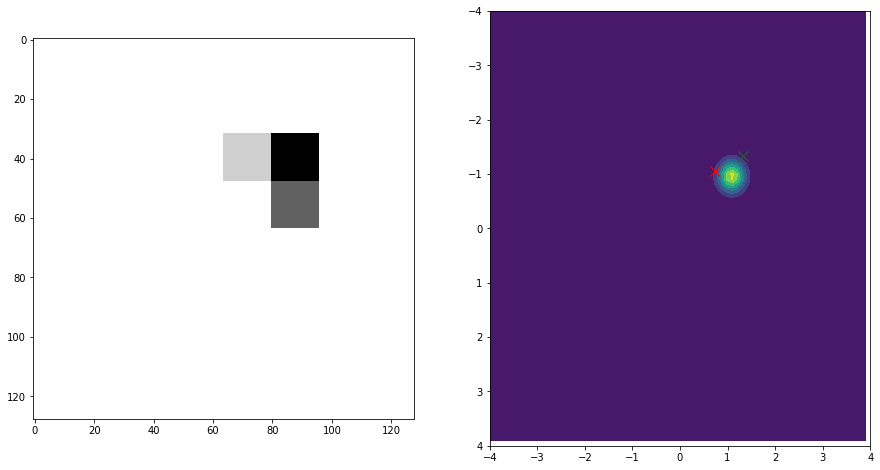

In [106]:
x_test = mnist.test.images[0]
i_offset, j_offset = -20, 20

i_offset_normalized, j_offset_normalized = i_offset / 15, j_offset / 15
coord_values = [(i_offset_normalized, j_offset_normalized)]

v, w = generate_vector_data_with_offset_from_x(x_test, i_offset, j_offset)
values = [v]

mu_test, std_test, hypo_test = sess.run([mu, std, hypo], feed_dict={x_input: values})
print(mu_test)
print(std_test)
print(hypo_test)

DIM1 = 0
DIM2 = 1
axe_x, axe_y = np.mgrid[-4:4:.1, -4:4:.1]
q = multivariate_normal(np.fliplr(mu_test)[0], np.fliplr(std_test)[0]**2 * np.eye(LATENT_DIM))
pos = np.empty(axe_x.shape + (LATENT_DIM,))
pos[:, :, DIM1] = axe_x; pos[:, :, DIM2] = axe_y

plt.figure(figsize = (15, 8))

plt.subplot(1,2,1)
plt.imshow(w.get_image(), cmap = 'gray_r', interpolation = 'nearest')

plt.subplot(1,2,2)
plt.contourf(axe_x, axe_y, q.pdf(pos))

plt.plot(hypo_test[0][DIM2], hypo_test[0][DIM1], 'xr', markersize = 10)
plt.plot(coord_values[0][DIM2], coord_values[0][DIM1], 'xg', markersize = 10)

plt.xlim(-4, 4)
plt.ylim(-4, 4)

plt.gca().invert_yaxis()



In [82]:
coord_values

[(-20, 20)]